In [1]:

import os
import uuid
import base64
from IPython import display
from unstructured.partition.pdf import partition_pdf
# from langchain.chat_models import ChatOpenAI
from langchain_community.chat_models import ChatOllama
from langchain_community import embeddings

# from langchain.embeddings import OpenAIEmbeddings
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage, SystemMessage
from langchain.schema.document import Document
from langchain.vectorstores import FAISS
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [2]:
output_path = "./test_images"


In [3]:
raw_pdf_elements = partition_pdf(
    filename="C:\\Users\\Barani\\Desktop\\chatbot\\dogs.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=output_path,
)

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

In [4]:
text_elements = []
table_elements = []

text_summaries = []
table_summaries = []

summary_prompt = """
Summarize the following {element_type}:
{element}
"""
summary_chain = LLMChain(
    llm=ChatOllama(model="mistral",temperature=0 ),
    prompt=PromptTemplate.from_template(summary_prompt)
)

for e in raw_pdf_elements:
    if 'CompositeElement' in repr(e):
        text_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'text', 'element': e})
        text_summaries.append(summary)

    elif 'Table' in repr(e):
        table_elements.append(e.text)
        summary = summary_chain.run({'element_type': 'table', 'element': e})
        table_summaries.append(summary)

c:\Users\Barani\Desktop\chatbot\multimodel\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [5]:
image_elements = []

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

In [6]:
for i in os.listdir(output_path):
    if i.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, i)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)

In [7]:
len(image_elements)

11

In [8]:
image_elements[0]

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCABXAH4DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDg6KK+ifCGjaJq/hLTb670HSWuJYf3jCyjG4gkZ6d8Zr369dUUm1c4KcOd2PnairurzC41m8lEMMIMzYjhjCIozgAAcAVVhlME8cqqjFGDBXUMpwc4IPBHsa2TurkDKK9L+K9tY2cWixWGmWNoJ4mmkNvbojMeMDIGccnitKL

In [10]:
import os
import ollama
from tqdm import tqdm
import base64
from PIL import Image
from io import BytesIO

# Initialize an empty list to store the results
img_summaries = []


# Iterate over all image strings in the list with a tqdm progress bar
for image_string in tqdm(image_elements, desc="Processing images"):
    # Decode the image string using utf-8 encoders
    img_data = base64.b64decode(image_string)
    img = Image.open(BytesIO(img_data))
    
    # Save the image to a temporary file
    img.save("temp.jpg")
    
    # Call the chat function with the image file
    res = ollama.chat(
        model="llava",
        messages=[
            {
                'role':'user',
                'content':'Describe this image :',
                'images':["temp.jpg"]
            }
        ]
    )
    
    # Append the result to the image_summary list
    img_summaries.append(res['message']['content'])

# Print the image_summary list
print(img_summaries)


Processing images: 100%|██████████| 11/11 [04:11<00:00, 22.84s/it]

[' The image features a logo that reads "USDA" in bold, capitalized letters. Below the text, there is a small graphic or symbol, which appears to be stylized depiction of farmland, crops, or fields. To the right of the text and graphic, there\'s an emblem with the letters "USDA" again, indicating that this logo represents the United States Department of Agriculture. The overall color scheme consists of various shades of blue and white, which are often associated with cleanliness, trustworthiness, and agriculture. The background is a gradient of light to dark blue. ', " The image shows a close-up of a dog's mouth with its tongue visible. There are two red areas on the gums, one larger and the other smaller, which seem to be areas of concern or injury. A yellow arrow has been drawn over these red spots, indicating that these might be important for examination or treatment. The background is not clear, focusing attention on the dog's mouth. There are no visible texts within the image. ", 

In [11]:
len(img_summaries)

11

In [12]:
img_summaries[0]

' The image features a logo that reads "USDA" in bold, capitalized letters. Below the text, there is a small graphic or symbol, which appears to be stylized depiction of farmland, crops, or fields. To the right of the text and graphic, there\'s an emblem with the letters "USDA" again, indicating that this logo represents the United States Department of Agriculture. The overall color scheme consists of various shades of blue and white, which are often associated with cleanliness, trustworthiness, and agriculture. The background is a gradient of light to dark blue. '

In [13]:
img_summaries[1]

" The image shows a close-up of a dog's mouth with its tongue visible. There are two red areas on the gums, one larger and the other smaller, which seem to be areas of concern or injury. A yellow arrow has been drawn over these red spots, indicating that these might be important for examination or treatment. The background is not clear, focusing attention on the dog's mouth. There are no visible texts within the image. "

In [14]:
documents = []
retrieve_contents = []

for e, s in zip(text_elements, text_summaries):
    i = str(uuid.uuid4())
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'text',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(table_elements, table_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'table',
            'original_content': e
        }
    )
    retrieve_contents.append((i, e))
    documents.append(doc)

for e, s in zip(image_elements, img_summaries):
    doc = Document(
        page_content = s,
        metadata = {
            'id': i,
            'type': 'image',
            'original_content': e
        }
    )
    retrieve_contents.append((i, s))
    documents.append(doc)

vectorstore = FAISS.from_documents(documents=documents, embedding=embeddings.OllamaEmbeddings(model='nomic-embed-text'))

In [15]:
vectorstore.save_local("new_dog_faiss_index")

In [2]:
embeddings = embeddings.OllamaEmbeddings(model='nomic-embed-text')


In [3]:
db = FAISS.load_local("new_dog_faiss_index", embeddings,allow_dangerous_deserialization=True)

In [4]:
prompt_template = """
You are a vet doctor and an expert in analyzing dog's health.
Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
Don't answer if you are not sure and decline to answer and say "Sorry, I don't have much information about it."
Just return the helpful answer in as much as detailed possible.
Answer:
"""

In [5]:
qa_chain = LLMChain(llm=ChatOllama(model="mistral", temperature=0),
                        prompt=PromptTemplate.from_template(prompt_template))

In [11]:

def answer(question):
    relevant_docs = db.similarity_search(question)
    context = ""
    relevant_images = []
    for d in relevant_docs:
        if d.metadata['type'] == 'text':
            context += '[text]' + d.metadata['original_content']
        elif d.metadata['type'] == 'table':
            context += '[table]' + d.metadata['original_content']
        elif d.metadata['type'] == 'image':
            context += '[image]' + d.page_content
            relevant_images.append(d.metadata['original_content'])
    result = qa_chain.run({'context': context, 'question': question})
    return result, relevant_images

In [12]:
result, relevant_images = answer("What is Gingivitis?")
print(result)

 Gingivitis is a condition characterized by inflammation or redness of the gums around the teeth in dogs. It is an early stage of periodontal disease (PD), and its primary cause is bacterial plaque accumulation on the teeth surface. The gums may appear mildly red, swollen, or bleed easily when touched or during chewing. At this stage, there is usually no significant loss of teeth, but if left untreated, it can progress to more severe forms of PD, leading to tooth loss and other health issues. Regular dental check-ups and proper oral hygiene are essential for preventing and managing gingivitis in dogs.


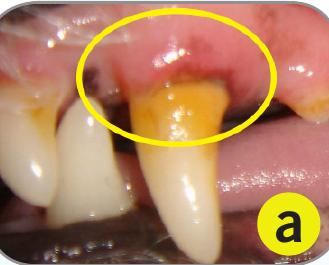

In [15]:
display.display(display.Image(base64.b64decode(relevant_images[2])))

In [10]:
type(relevant_images)

bytes

In [16]:
result, relevant_images = answer("What is Early Periodontitis?")
print(result)

 Early Periodontitis, also known as Grade I! periodontitis, is an early stage of periodontal disease (PD) in dogs. In this stage, there are mild signs of inflammation and tartar build-up on the teeth. The gums may exhibit some redness, but they remain attached to the teeth with no missing or loose teeth yet. This stage is crucial because if left untreated, it can progress to more severe forms of PD, leading to tooth loss and other health issues for your dog. Regular dental check-ups and proper oral hygiene practices are essential in preventing and managing early periodontitis effectively.


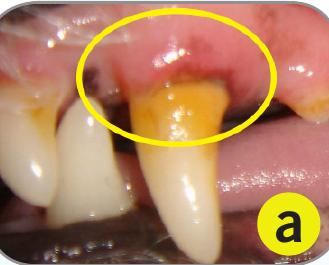

In [17]:
display.display(display.Image(base64.b64decode(relevant_images[0])))